# **HATE SPEECH DETECTION**

---


**Importing Required Libraries**

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

import speech_recognition as sr

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

**Connecting with Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading Dataset**

In [6]:
ds = pd.read_csv("/content/drive/MyDrive/Projects/Hate_speech_detection/hate_speech.csv")
ds.head(5)

Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [7]:
ds.rename(columns = {'class':'hs_class'}, inplace=True)

# **Data Information**

In [8]:
ds.shape

(24783, 7)

In [9]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   hs_class            24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [10]:
ds.describe().T

count          mean          std  min     25%      50%  \
Unnamed: 0          24783.0  12681.192027  7299.553863  0.0  6372.5  12703.0   
count               24783.0      3.243473     0.883060  3.0     3.0      3.0   
hate_speech         24783.0      0.280515     0.631851  0.0     0.0      0.0   
offensive_language  24783.0      2.413711     1.399459  0.0     2.0      3.0   
neither             24783.0      0.549247     1.113299  0.0     0.0      0.0   
hs_class            24783.0      1.110277     0.462089  0.0     1.0      1.0   

                        75%      max  
Unnamed: 0          18995.5  25296.0  
count                   3.0      9.0  
hate_speech             0.0      7.0  
offensive_language      3.0      9.0  
neither                 0.0      9.0  
hs_class                1.0      2.0

**Deleting Unwanted Columns**

In [11]:
ds.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'], axis=1, inplace=True)
ds.head(5)

hs_class                                              tweet
0         2  !!! RT @mayasolovely: As a woman you shouldn't...
1         1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2         1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3         1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4         1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [12]:
ds.isnull().sum()

hs_class    0
tweet       0
dtype: int64

**Class Labels**

In [13]:
ds['hs_class'].unique()

array([2, 1, 0])

In [14]:
class_labels = {0:'Hate', 1:'Offensive', 2:'Neither'}
class_labels

{0: 'Hate', 1: 'Offensive', 2: 'Neither'}

In [15]:
ds['hs_class'].value_counts()

1    19190
2     4163
0     1430
Name: hs_class, dtype: int64

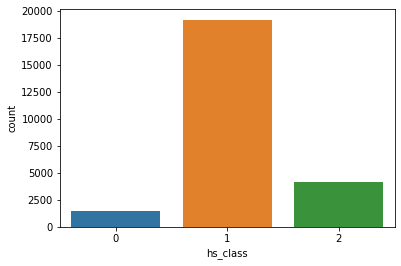

In [16]:
sns.countplot('hs_class',data=ds)

In [17]:
ds['text length'] = ds['tweet'].apply(len)
ds.head()

hs_class                                              tweet  text length
0         2  !!! RT @mayasolovely: As a woman you shouldn't...          140
1         1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...           85
2         1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...          120
3         1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...           62
4         1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...          137

**Visualizating Target Class**

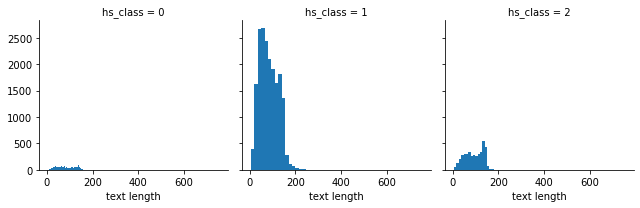

In [18]:
graph = sns.FacetGrid(data=ds, col='hs_class')
graph.map(plt.hist, 'text length', bins=50)

# **Preprocessing of Tweets**

In [19]:
tweet = ds.tweet
tweet

0        !!! RT @mayasolovely: As a woman you shouldn't...
1        !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3        !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4        !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
                               ...                        
24778    you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779    you've gone and broke the wrong heart baby, an...
24780    young buck wanna eat!!.. dat nigguh like I ain...
24781                youu got wild bitches tellin you lies
24782    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24783, dtype: object

**Downloading Nltk Tools**

In [20]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(tweet):  
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    tweet_lower = newtweet.str.lower()
    
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    tokenized_tweet = tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        tweets_p =  tokenized_tweet
    
    return tweets_p

processed_tweets = preprocess(tweet)   

ds['processed_tweets'] = processed_tweets
ds[["tweet","processed_tweets"]].head(5)

tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   

                                    processed_tweets  
0  woman complain clean hous amp man alway take t...  
1  boy dat cold tyga dwn bad cuffin dat hoe st place  
2         dawg ever fuck bitch start cri confus shit  
3                                   look like tranni  
4     shit hear might true might faker bitch told ya

In [22]:
for i in class_labels:
  print("Class:",class_labels[i],"\n","-"*50)
  text = list(ds.query('hs_class == {}'.format(i))['processed_tweets'].head(5))
  print(*text,"\n",sep="\n")

Class: Hate 
 --------------------------------------------------
queer gaywad
alsarabsss he beaner smh tell he mexican
fuck gay blacklist hoe hold tehgodclan anyway
lmfaoooo hate black peopl black peopl nigger
least nigger lmfao


Class: Offensive 
 --------------------------------------------------
boy dat cold tyga dwn bad cuffin dat hoe st place
dawg ever fuck bitch start cri confus shit
look like tranni
shit hear might true might faker bitch told ya
shit blow claim faith somebodi still fuck hoe


Class: Neither 
 --------------------------------------------------
woman complain clean hous amp man alway take trash
momma said pussi cat insid doghous
simplyaddictedtoguy woof woof hot scalli lad
woof woof hot sole
lemmi eat oreo amp dish one oreo lol




**Visualizating tweets**

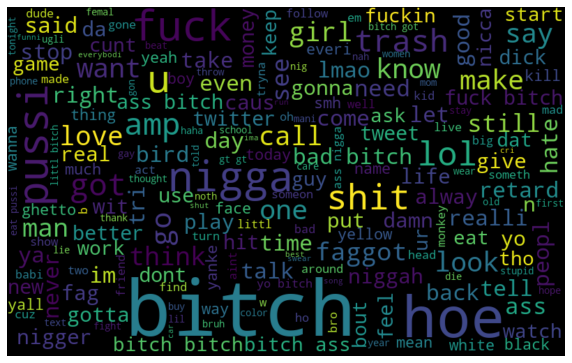

In [23]:
# most commonly used words
all_words = ' '.join([text for text in ds['processed_tweets'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

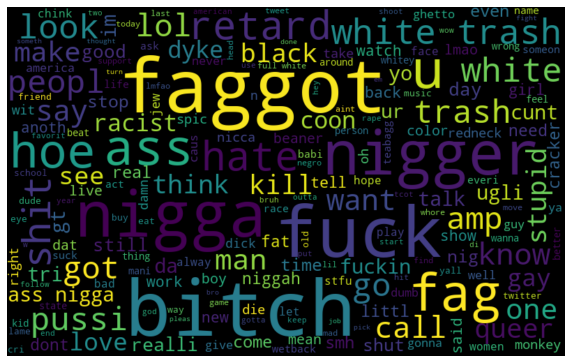

In [24]:
# most commonly used words for hatred speech
hatred_words = ' '.join([text for text in ds['processed_tweets'][ds['hs_class'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

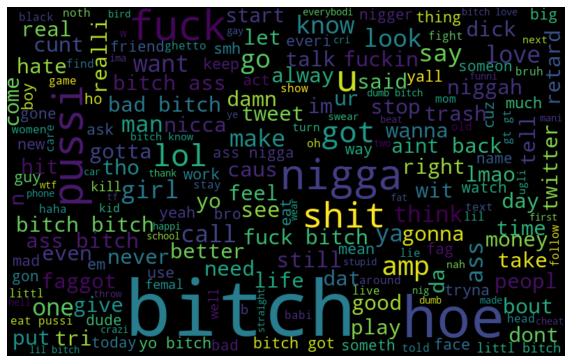

In [25]:
# most commonly used words for offensive speech
offensive_words = ' '.join([text for text in ds['processed_tweets'][ds['hs_class'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(offensive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Feature Engineering**

In [26]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.75, min_df=5, max_features=10000)
tfidf = tfidf_vectorizer.fit_transform(ds['processed_tweets'] )
tfidf

<24783x6441 sparse matrix of type '<class 'numpy.float64'>'
	with 189618 stored elements in Compressed Sparse Row format>

**Train Test Spliting**

In [27]:
X = tfidf
y = ds['hs_class'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# **Model Building**

In [28]:
# creating a dictionary to store all accuracies
models = {}

**Logistic Regression**

In [29]:
lrmodel = LogisticRegression(max_iter=1000)

lrmodel.fit(X_train, y_train)

y_pred = lrmodel.predict(X_test)

acc = accuracy_score(y_test, y_pred)

models['Logistic Regression'] = round(acc*100, 2)
print("\nAccuracy Score:" , acc)


Accuracy Score: 0.8975186604801291


**Random Forest Classifier**

In [30]:
rfmodel = RandomForestClassifier()

rfmodel.fit(X_train, y_train)

y_preds = rfmodel.predict(X_test)

acc1 = accuracy_score(y_test, y_preds)

models['RandomForest Classifier'] = round(acc*100, 2)
print("Accuracy Score:",acc1)

Accuracy Score: 0.9039741779301997



**Linear Support Vector Classifier**

In [31]:
svcmodel = LinearSVC(random_state=20)

svcmodel.fit(X_train, y_train)

y_pred = svcmodel.predict(X_test)

acc = accuracy_score(y_test, y_pred)

models['LinearSupportVector Classifier'] = round(acc*100, 2)
print("Accuracy Score:" , acc)

Accuracy Score: 0.8932822271535202


**AdaBoost Classifier**

In [32]:
adamodel = AdaBoostClassifier()

adamodel.fit(X_train, y_train)

y_pred = adamodel.predict(X_test)

acc = accuracy_score(y_test, y_pred)

models['AdaBoost Classifier'] = round(acc*100, 2)
print("Accuracy Score:" , acc)

Accuracy Score: 0.9055880572927174


**XGBoost Classifier**

In [33]:
xgbmodel = XGBClassifier()

xgbmodel.fit(X_train, y_train)

y_pred = xgbmodel.predict(X_test)

acc = accuracy_score(y_test, y_pred)

models['XGBoost Classifier'] = round(acc*100, 2)
print("Accuracy Score:" , acc)

Accuracy Score: 0.8979221303207585


**Finding Best Model**

In [34]:
for i,j in models.items():
  print("{} : {}%".format(i,j))

Logistic Regression : 89.75%
RandomForest Classifier : 89.75%
LinearSupportVector Classifier : 89.33%
AdaBoost Classifier : 90.56%
XGBoost Classifier : 89.79%


In [35]:
bestmodel = max(models, key= lambda x: models[x])
print("{} is the best model with accuracy of {}%".format(bestmodel, models[bestmodel]))

AdaBoost Classifier is the best model with accuracy of 90.56%


**Tuning the Best model**

In [42]:
parameters = {'n_estimators': [100, 200, 300],
               'learning_rate': [(0.97 + x / 100) for x in range(0, 3)],
            }
bestmodel = GridSearchCV(estimator = adamodel, param_grid = parameters, scoring = 'accuracy', cv = 3, n_jobs = -1)
bestmodel.fit(X_train, y_train)
print("Accuracy score : {}% \nBest parameters : {}".format(round(bestmodel.best_score_*100,2), bestmodel.best_params_))

Accuracy score : 95.6% 
Best parameters : {'learning_rate': 0.99, 'n_estimators': 100}


# **New Data Prediction**

In [37]:
r = sr.Recognizer()

**Extracting text from Audio(.wav) file**

In [48]:
def predict_output(filename,model):
    with sr.AudioFile(filename) as source:
        audio_data = r.record(source)
        text = r.recognize_google(audio_data)
        print("Text: ", text)
        text = tfidf_vectorizer.transform([text])
        return class_labels[model.predict(text)[0]]

**Model result**

In [51]:
#neither class audio
filename = "/content/drive/MyDrive/Projects/Hate_speech_detection/test_audio/neither_1.wav"
result = predict_output(filename, bestmodel)
print("Result: ", result)

result2:
{   'alternative': [   {   'confidence': 0.93308288,
                           'transcript': 'woman complains clean house amp man '
                                         'always take trash'},
                       {   'transcript': 'woman complains clean house amp men '
                                         'always take trash'},
                       {   'transcript': 'woman complains clean how Sam man '
                                         'always take trash'},
                       {   'transcript': 'woman complains clean house ant man '
                                         'always take trash'},
                       {   'transcript': 'woman complains clean house Ant-Man '
                                         'always take trash'}],
    'final': True}
Text:  woman complains clean house amp man always take trash
Result:  Neither


In [52]:
#offensive class audio
filename = "/content/drive/MyDrive/Projects/Hate_speech_detection/test_audio/offensive_1.wav"
result = predict_output(filename, bestmodel)
print("Result: ", result)

result2:
{   'alternative': [   {   'confidence': 0.91785657,
                           'transcript': 'stomach pain like move fuck a '
                                         'niggerate bitch'},
                       {   'transcript': 'stomach pain like move fuck a nigga '
                                         'rate bitch'},
                       {   'transcript': 'stomach pain like move fuck a nigga '
                                         'rape bitch'},
                       {   'transcript': 'stomach pain like move fucking nigga '
                                         'rate bitch'},
                       {   'transcript': 'stomach pain like move fucking nigga '
                                         'rape bitch'}],
    'final': True}
Text:  stomach pain like move fuck a niggerate bitch
Result:  Offensive
